# MIT-BIH AFDB — AFib Detection with KanResWideX

**Dataset:** [MIT-BIH Atrial Fibrillation Database (old directory)](https://physionet.org/content/afdb/1.0.0/old/)  
**Task:** Binary classification — AFib vs Non-AFib  
**Model:** KanResWideX (1D CNN with residual blocks)


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import sys
sys.path.append("/content/drive/Othercomputers/Min_PC/Skrivebord/Afib-Master/Experiments")


In [3]:
!nvidia-smi

Mon Feb  9 20:17:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!pip install wfdb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 93.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
dask-cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.0 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.0 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.0 which is incompatible.
cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.0 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.0 which is incompatible.


## 1. Imports & Setup

In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import wfdb
from model import KanResWideX

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Configuration

In [7]:
class Config:
    # Data path on Google Drive
    data_dir = "/content/drive/Othercomputers/Min_PC/Skrivebord/Afib-Master/data/MIT-BIH AFDB/files"

    # Signal parameters
    fs = 250                              # Sampling frequency (Hz)
    channel = 0                           # ECG channel (0 = ECG1)

    # Windowing
    window_seconds = 4                    # Window duration in seconds
    window_size = fs * window_seconds     # 1000 samples
    stride_seconds = 2                    # Stride (50% overlap)
    stride_size = fs * stride_seconds     # 500 samples

    # Labels: binary — AFib=1, everything else=0
    label_map = {"AF": 1, "N": 0, "AFL": 0, "J": 0}
    skip_records = ["00735", "03665"]     # No signal files

    # Training
    num_classes = 2
    batch_size = 64
    num_epochs = 30
    learning_rate = 1e-3
    weight_decay = 1e-4

    # Split ratios (patient-level)
    test_size = 0.2
    val_size = 0.25   # 0.25 of 0.8 = 0.2 overall
    random_seed = 42

config = Config()

# Verify data path exists
assert os.path.exists(config.data_dir), f"Data path not found: {config.data_dir}"
print(f"Data path OK: {config.data_dir}")
print(f"Files found: {len(os.listdir(config.data_dir))}")
print(f"Window: {config.window_size} samples ({config.window_seconds}s)")
print(f"Stride: {config.stride_size} samples ({config.stride_seconds}s)")


Data path OK: /content/drive/Othercomputers/Min_PC/Skrivebord/Afib-Master/data/MIT-BIH AFDB/files
Files found: 132
Window: 1000 samples (4s)
Stride: 500 samples (2s)


## 3. Data Loading & Windowing Functions

In [8]:
def get_record_list(data_dir):
    """Find all valid record names with .dat files."""
    records = set()
    for f in os.listdir(data_dir):
        name, ext = os.path.splitext(f)
        if ext == ".dat":
            records.add(name)
    records = sorted(records)
    print(f"Found {len(records)} records with signal files: {records}")
    return records


def load_rhythm_annotations(data_dir, record_name):
    """
    Load rhythm annotations from .atr file.
    Returns list of (start_sample, end_sample, rhythm_label) tuples.
    """
    try:
        ann = wfdb.rdann(os.path.join(data_dir, record_name), "atr")
    except Exception as e:
        print(f"  Warning: Could not read annotations for {record_name}: {e}")
        return []

    try:
        record = wfdb.rdheader(os.path.join(data_dir, record_name))
        total_samples = record.sig_len
    except Exception:
        total_samples = 10 * 3600 * config.fs

    segments = []
    for i in range(len(ann.sample)):
        start = ann.sample[i]
        end = ann.sample[i + 1] if i + 1 < len(ann.sample) else total_samples

        label = ann.aux_note[i] if ann.aux_note[i] else None
        if label:
            label = label.strip().strip("(").strip()
            if label in ("AFIB", "AF"):
                label = "AF"
            elif label in ("AFL",):
                label = "AFL"
            elif label in ("J",):
                label = "J"
            else:
                label = "N"

        if label and end > start:
            segments.append((start, end, label))

    return segments


def create_windows_for_record(data_dir, record_name, config):
    """
    Load signal + annotations for one record, create labeled windows.
    Label via majority vote: >50% AFib samples -> AFib window.
    """
    try:
        record = wfdb.rdrecord(os.path.join(data_dir, record_name), channels=[config.channel])
        signal = record.p_signal[:, 0]
    except Exception as e:
        print(f"  Warning: Could not read signal for {record_name}: {e}")
        return None, None, None

    segments = load_rhythm_annotations(data_dir, record_name)
    if not segments:
        print(f"  Warning: No rhythm annotations for {record_name}")
        return None, None, None

    total_samples = len(signal)

    # Per-sample label array
    sample_labels = np.zeros(total_samples, dtype=np.int64)
    afib_events = 0
    for start, end, rhythm in segments:
        if rhythm == "AF":
            sample_labels[max(start, 0):min(end, total_samples)] = 1
            afib_events += 1

    # Sliding windows
    windows, labels = [], []
    win_start = 0
    while win_start + config.window_size <= total_samples:
        win_end = win_start + config.window_size
        win_signal = signal[win_start:win_end]

        # Skip bad windows
        if np.any(np.isnan(win_signal)):
            win_start += config.stride_size
            continue
        std = np.std(win_signal)
        if std < 1e-6:
            win_start += config.stride_size
            continue

        # Z-score normalize
        win_signal = (win_signal - np.mean(win_signal)) / std

        # Majority label
        afib_ratio = np.mean(sample_labels[win_start:win_end])
        label = 1 if afib_ratio > 0.5 else 0

        windows.append(win_signal)
        labels.append(label)
        win_start += config.stride_size

    if not windows:
        return None, None, None

    windows = np.array(windows, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    stats = {
        "afib_events": afib_events,
        "total_windows": len(labels),
        "afib_windows": int(np.sum(labels == 1)),
        "non_afib_windows": int(np.sum(labels == 0)),
    }
    return windows, labels, stats

print("Functions defined.")


Functions defined.


## 4. Load All Records

In [9]:
records = get_record_list(config.data_dir)
records = [r for r in records if r not in config.skip_records]

all_record_data = {}
total_stats = {"afib_events": 0, "total_windows": 0, "afib_windows": 0, "non_afib_windows": 0}

print(f"\n{'Record':<10} {'AFib Events':<15} {'Total Win':<12} {'AFib Win':<12} {'Non-AFib Win':<15}")
print("-" * 65)

for record_name in records:
    windows, labels, stats = create_windows_for_record(config.data_dir, record_name, config)
    if windows is not None:
        all_record_data[record_name] = (windows, labels)
        for key in total_stats:
            total_stats[key] += stats[key]
        print(f"{record_name:<10} {stats['afib_events']:<15} "
              f"{stats['total_windows']:<12} {stats['afib_windows']:<12} "
              f"{stats['non_afib_windows']:<15}")

print("-" * 65)
print(f"{'TOTAL':<10} {total_stats['afib_events']:<15} "
      f"{total_stats['total_windows']:<12} {total_stats['afib_windows']:<12} "
      f"{total_stats['non_afib_windows']:<15}")


Found 23 records with signal files: ['04015', '04043', '04048', '04126', '04746', '04908', '04936', '05091', '05121', '05261', '06426', '06453', '06995', '07162', '07859', '07879', '07910', '08215', '08219', '08378', '08405', '08434', '08455']

Record     AFib Events     Total Win    AFib Win     Non-AFib Win   
-----------------------------------------------------------------
04015      7               18410        119          18291          
04043      82              18407        3966         14441          
04048      7               18410        180          18230          
04126      7               18410        688          17722          
04746      5               18410        9776         8634           
04908      8               18410        1541         16869          
04936      36              18410        13281        5129           
05091      8               18410        41           18369          
05121      20              18410        11604        6806           

## 5. Patient-Level Train / Val / Test Split

Records (patients) are split — **not** windows — to avoid data leakage.

In [10]:
record_names = sorted(all_record_data.keys())

train_records, test_records = train_test_split(
    record_names, test_size=config.test_size, random_state=config.random_seed
)
train_records, val_records = train_test_split(
    train_records, test_size=config.val_size, random_state=config.random_seed
)

def merge_records(record_list):
    w_list, l_list = [], []
    for r in record_list:
        w, l = all_record_data[r]
        w_list.append(w)
        l_list.append(l)
    return np.concatenate(w_list), np.concatenate(l_list)

X_train, y_train = merge_records(train_records)
X_val, y_val = merge_records(val_records)
X_test, y_test = merge_records(test_records)

print(f"Train records ({len(train_records)}): {train_records}")
print(f"Val records   ({len(val_records)}):  {val_records}")
print(f"Test records  ({len(test_records)}):  {test_records}")
print()
print(f"Train: {len(y_train):,} windows (AFib: {np.sum(y_train==1):,}, Non-AFib: {np.sum(y_train==0):,})")
print(f"Val:   {len(y_val):,} windows (AFib: {np.sum(y_val==1):,}, Non-AFib: {np.sum(y_val==0):,})")
print(f"Test:  {len(y_test):,} windows (AFib: {np.sum(y_test==1):,}, Non-AFib: {np.sum(y_test==0):,})")


Train records (13): ['05091', '08378', '07859', '08434', '07162', '08219', '04936', '04048', '08455', '04126', '07910', '06426', '08405']
Val records   (5):  ['06995', '04043', '04746', '06453', '04908']
Test records  (5):  ['07879', '05261', '04015', '05121', '08215']

Train: 239,318 windows (AFib: 106,060, Non-AFib: 133,258)
Val:   90,286 windows (AFib: 24,147, Non-AFib: 66,139)
Test:  92,050 windows (AFib: 37,902, Non-AFib: 54,148)


## 6. PyTorch Dataset & DataLoaders

In [11]:
class ECGDataset(Dataset):
    def __init__(self, windows, labels):
        self.windows = torch.FloatTensor(windows).unsqueeze(1)  # (N, 1, 1000)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

train_loader = DataLoader(ECGDataset(X_train, y_train), batch_size=config.batch_size,
                           shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(ECGDataset(X_val, y_val), batch_size=config.batch_size,
                           shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(ECGDataset(X_test, y_test), batch_size=config.batch_size,
                           shuffle=False, num_workers=0, pin_memory=True)

print(f"DataLoaders ready. Batch size: {config.batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


DataLoaders ready. Batch size: 64
  Train batches: 3740
  Val batches:   1411
  Test batches:  1439


## 7. Model, Loss, Optimizer

In [13]:
model = KanResWideX(input_channels=1, output_size=config.num_classes)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model: KanResWideX")
print(f"Total parameters: {total_params:,}")
print(model)

# Class weights for imbalance
class_counts = Counter(y_train.tolist())
class_weights = torch.FloatTensor([
    len(y_train) / (config.num_classes * class_counts[i])
    for i in range(config.num_classes)
]).to(device)
print(f"\nClass weights: {class_weights.cpu().numpy()}")

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)


Model: KanResWideX
Total parameters: 1,647,714
KanResWideX(
  (init_block): KanResInit(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (res_modules): ModuleList(
    (0-7): 8 x KanResModule(
      (conv1): Conv1d(32, 64, kernel_size=(50,), stride=(1,), padding=same)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv1d(64, 32, kernel_size=(50,), stride=(1,), padding=same)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
  )
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (f

## 8. Training & Evaluation Functions

In [16]:
from tqdm.notebook import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    total = len(all_targets)
    return running_loss / total, accuracy_score(all_targets, all_preds), \
           np.array(all_preds), np.array(all_targets)

print("Training functions ready.")

Training functions ready.


## 9. Training Loop

In [18]:
import time

print(f"Training for {config.num_epochs} epochs...\n")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12} {'Time':<8}")
print("-" * 66)

best_val_loss = float("inf")
best_model_state = None
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

total_start = time.time()

for epoch in range(1, config.num_epochs + 1):
    epoch_start = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    epoch_time = time.time() - epoch_start

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"{epoch:<8} {train_loss:<12.4f} {train_acc:<12.4f} {val_loss:<12.4f} {val_acc:<12.4f} {epoch_time:<.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

total_time = time.time() - total_start
print(f"\nTraining complete in {total_time/60:.1f} minutes.")

Training for 30 epochs...

Epoch    Train Loss   Train Acc    Val Loss     Val Acc      Time    
------------------------------------------------------------------


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

1        0.0341       0.9897       2.0146       0.6350       354.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

2        0.0270       0.9915       0.7902       0.6972       345.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

3        0.0223       0.9930       0.7011       0.7875       336.6s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

4        0.0206       0.9936       2.1104       0.5458       335.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

5        0.0188       0.9942       1.0157       0.6907       333.8s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

6        0.0179       0.9944       1.2571       0.6840       333.5s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

7        0.0170       0.9945       1.5713       0.6439       333.5s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

8        0.0162       0.9949       1.4180       0.6172       331.5s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

9        0.0154       0.9952       1.3716       0.6125       330.7s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

10       0.0115       0.9962       1.9589       0.6292       329.9s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

11       0.0107       0.9965       1.0605       0.6790       327.1s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

12       0.0101       0.9966       1.1848       0.6316       327.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

13       0.0101       0.9966       1.8955       0.6298       326.9s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

14       0.0097       0.9969       1.8483       0.6087       327.6s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

15       0.0094       0.9968       2.0727       0.5424       327.3s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

16       0.0064       0.9977       2.2673       0.6102       326.8s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

17       0.0057       0.9981       2.3669       0.6149       326.7s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

18       0.0055       0.9980       2.3366       0.6202       326.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

19       0.0051       0.9982       1.2067       0.6865       327.3s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

20       0.0051       0.9982       1.9337       0.6376       327.6s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

21       0.0048       0.9984       1.9419       0.6508       326.6s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

22       0.0030       0.9991       2.8897       0.6200       326.2s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

23       0.0025       0.9992       2.5679       0.6259       326.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

24       0.0023       0.9993       2.9889       0.6143       326.3s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

25       0.0022       0.9993       2.6723       0.6086       326.7s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

26       0.0021       0.9993       2.6996       0.6287       326.4s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

27       0.0019       0.9994       3.3514       0.6224       326.2s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

28       0.0011       0.9997       3.3025       0.6070       326.6s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

29       0.0010       0.9997       3.1568       0.6152       326.0s


Training:   0%|          | 0/3740 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1411 [00:00<?, ?it/s]

30       0.0009       0.9998       3.4094       0.6070       326.0s

Training complete in 165.0 minutes.


## 10. Training Curves

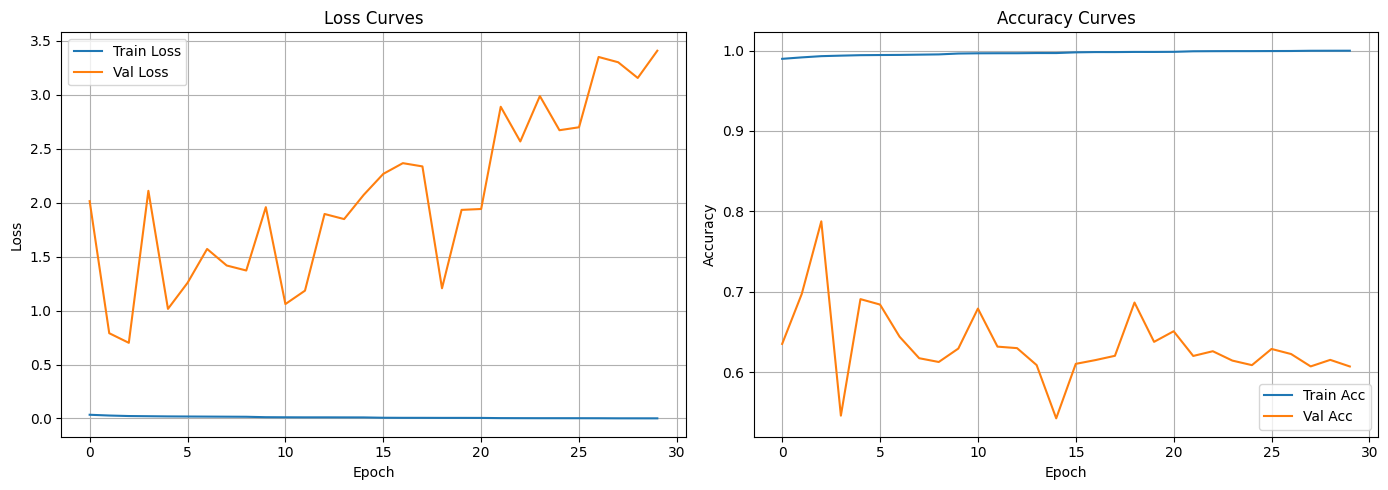

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history["train_loss"], label="Train Loss")
ax1.plot(history["val_loss"], label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Curves")
ax1.legend()
ax1.grid(True)

ax2.plot(history["train_acc"], label="Train Acc")
ax2.plot(history["val_acc"], label="Val Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy Curves")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


## 11. Test Set Evaluation

In [20]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

test_loss, test_acc, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

cm = confusion_matrix(test_targets, test_preds, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

precision = precision_score(test_targets, test_preds, pos_label=1, zero_division=0)
recall_val = recall_score(test_targets, test_preds, pos_label=1, zero_division=0)
f1 = f1_score(test_targets, test_preds, pos_label=1, zero_division=0)

print("=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print()
print("Confusion Matrix:")
print(f"                    Predicted")
print(f"                 Non-AFib   AFib")
print(f"  Actual Non-AFib  {tn:>6}   {fp:>6}   (TN, FP)")
print(f"  Actual AFib      {fn:>6}   {tp:>6}   (FN, TP)")
print()
print(f"  True Negatives  (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives  (TP): {tp}")
print()
print(f"  Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Precision:      {precision:.4f}")
print(f"  Recall:         {recall_val:.4f}")
print(f"  F1 Score:       {f1:.4f}")
print()
print("Full Classification Report:")
print(classification_report(
    test_targets, test_preds,
    target_names=["Non-AFib", "AFib"],
    digits=4
))


Evaluating:   0%|          | 0/1439 [00:00<?, ?it/s]

TEST SET RESULTS

Confusion Matrix:
                    Predicted
                 Non-AFib   AFib
  Actual Non-AFib   45485     8663   (TN, FP)
  Actual AFib        9899    28003   (FN, TP)

  True Negatives  (TN): 45485
  False Positives (FP): 8663
  False Negatives (FN): 9899
  True Positives  (TP): 28003

  Test Accuracy:  0.7983 (79.83%)
  Precision:      0.7637
  Recall:         0.7388
  F1 Score:       0.7511

Full Classification Report:
              precision    recall  f1-score   support

    Non-AFib     0.8213    0.8400    0.8305     54148
        AFib     0.7637    0.7388    0.7511     37902

    accuracy                         0.7983     92050
   macro avg     0.7925    0.7894    0.7908     92050
weighted avg     0.7976    0.7983    0.7978     92050



## 12. Confusion Matrix Heatmap

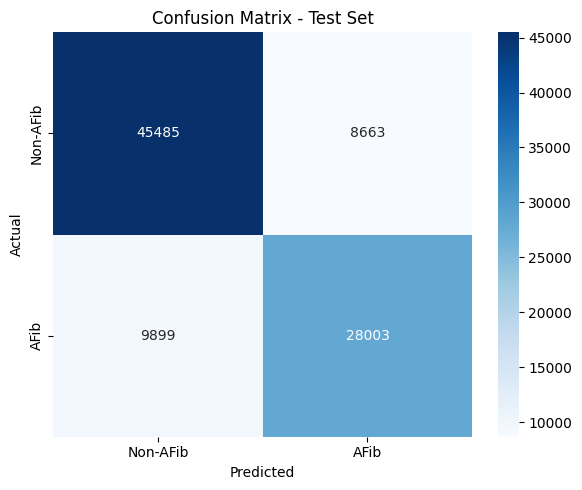

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-AFib", "AFib"],
            yticklabels=["Non-AFib", "AFib"], ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


## 13. Windowing Summary

In [22]:
print("=" * 60)
print("WINDOWING SUMMARY")
print("=" * 60)
print(f"  Window size:   {config.window_size} samples ({config.window_seconds}s)")
print(f"  Stride:        {config.stride_size} samples ({config.stride_seconds}s)")
print(f"  Total windows: {total_stats['total_windows']:,}")
print(f"  AFib windows:  {total_stats['afib_windows']:,}")
print(f"  Non-AFib win:  {total_stats['non_afib_windows']:,}")
print(f"  Total AFib rhythm segments across all records: {total_stats['afib_events']}")


WINDOWING SUMMARY
  Window size:   1000 samples (4s)
  Stride:        500 samples (2s)
  Total windows: 421,654
  AFib windows:  168,109
  Non-AFib win:  253,545
  Total AFib rhythm segments across all records: 291
